# PyTorch Compile
- 원래 사이트에서는 A Quick PyTorch 2.0 Tutorial이라고 나와 있는 부분임
    - https://www.learnpytorch.io/pytorch_2_intro
- PyTorch 2.0 부터 compile 기능이 나왔거나 강화되었거나 한 모양인데 잘 쓰면 좋아 보이니 정리
- Compile은 사실 GPU의 usage를 늘리는게 핵심이므로 다음과 같이 수정하는게 좋다
    - Batch size를 늘린다
    - Data size를 늘린다
    - Model size를 늘린다
    - Data transfer를 **줄인다**
- 참고로 Model Deployment는 대충 읽어보니 내가 하고 싶은거랑은 당장 관계가 없는 듯 하고 이런건 필요한때 찾아봐가면서 하는게 나으니 (e.g. 그 사이에 좋은 플랫폼/새로운 대세가 나온다던가) 그냥 쭉 읽어보고 넘어감

### 1. 환경 파악
- PyTorch 2 이상이어야 함
- GTX 3000번대 이상의 GPU를 가지고 있어야 함

### 2. Global device setting
- `with torch.device`를 이용해 특정 device가 default인 context 만들기
- `torch.set_default_device`를 이용해 default device setting하기

### 3. ResNet50으로 Compile의 효과 테스트 하기
- GPU memory limit test
    - 책에 나온 예제는 40GB VRAM을 가진 CPU를 전제로 한 예제라 3070ti에서 테스트할 때에는 여러 측면에서 크기를 줄여야 함
    - 책에 의하면 16GB 이상일 경우 batch size/image size를 128/224로 하는게 좋고 16GB이하인 경우 32/64 정도로 할 것을 추천함
- TF32
    - TensorFloat-32
    - combination of 16-bit and 32-bit floating point
    - faster matrix multiplication을 지원해 줌
    - `torch.backends.cuda.matmul.allow_tf32 = True`로 enable
- DataSet, DataLoader 준비

In [70]:
# After pytorch 2.0

import timeit
import torch
import torchvision

t_0 = timeit.default_timer()
model = torchvision.models.resnet50() # note: this could be any model
t_1 = timeit.default_timer()
compiled_model = torch.compile(model) # <- magic happens!
t_2 = timeit.default_timer()

print("Time to create model: {}".format(t_1 - t_0))
print("Time to compile model: {}".format(t_2 - t_1))

### Train model ### <- faster!

### Test model ### <- faster!

Time to create model: 0.2063912230000824
Time to compile model: 0.000974933999714267


In [71]:
# Check environment 
import torch

print('PyTorch version: {}'.format(torch.__version__)) # 2 이상이어야 함

# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")
  
  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

PyTorch version: 2.1.1+cu121
GPU name: NVIDIA_GeForce_RTX_3070_Ti_Laptop_GPU
GPU capability score: (8, 6)
GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.
GPU information:
Mon Jan 22 23:59:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.36                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    On  | 00000000:01:00.0  On |                  N/A |
| N/A   63C    P8              20W /  90W |

In [72]:
# 2. Global device setting
#
# with torch.device를 이용해 특정 device가 default인 context 만들기
#

import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
    # All tensors created in this block will be on device
    layer = torch.nn.Linear(20, 30)
    print(f"Layer weights are on device: {layer.weight.device}")
    print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [73]:
# 2. Global device setting
#
# torch.set_default_device를 이용해 default device setting하기
#

import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device globally
torch.set_default_device(device)

# All tensors created will be on the global device by default
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

# Set the device globally
torch.set_default_device('cpu')

# All tensors created will be on "cpu"
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0
Layer weights are on device: cpu
Layer creating data on device: cpu


In [74]:
import torch
import torchvision

def create_model(num_classes=10):
    """
    Creates a ResNet50 model with the latest weights and transforms via torchvision.
    """
    # Create model weights and transforms
    # use the latest weights (could also use .DEFAULT)
    model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    transforms = model_weights.transforms()

    # Setup model
    model = torchvision.models.resnet50(weights=model_weights)

    # Count the number of parameters in the model 
    total_params = sum(
        param.numel() for param in model.parameters() # <- all params
        # param.numel() for param in model.parameters() if param.requires_grad # <- only trainable params
    )

    print(f"Total parameters of model: {total_params} (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)")
    print(f"Model transforms:\n{transforms}")
    
    # Adjust the number of output features in model to match the number of classes in the dataset
    model.fc = torch.nn.Linear(in_features=2048, 
                               out_features=num_classes)
    return model, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

model, transforms = create_model()

Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [75]:
# GPU memory limit test

# Check available GPU memory and total GPU memory 
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 2.829 GB
Total GPU memory: 8.589 GB


In [76]:
# 책에 의하면 16GB 이상일 경우 batch size/image size를 128/224로 하는게 좋고 
# 16GB이하인 경우 32/128 정도로 할 것을 추천함

BATCH_SIZE = 32
IMAGE_SIZE = 224

transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE
print(f"Transforms:\n{transforms}")

Transforms:
ImageClassification(
    crop_size=224
    resize_size=224
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [77]:
if GPU_SCORE >= (8, 0):
    print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)")
    torch.backends.cuda.matmul.allow_tf32 = True
else:
    print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)")
    torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (8, 6), enabling TensorFloat32 (TF32) computing (faster on new GPUs)


In [78]:
# DataSet, DataLoader 준비

import os

# Create train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='.', 
                                             train=True, 
                                             download=True, 
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root='.', 
                                            train=False, # want the test split
                                            download=True, 
                                            transform=transforms)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

from torch.utils.data import DataLoader

# Create DataLoaders
NUM_WORKERS = os.cpu_count() # <- use all available CPU cores (this number can be tweaked through experimentation but generally more workers means faster dataloading from CPU to GPU)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")
print(f"Using number of workers: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

Files already downloaded and verified
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000
Train dataloader length: 1563 batches of size 32
Test dataloader length: 313 batches of size 32
Using number of workers: 20 (generally more workers means faster dataloading from CPU to GPU)


In [79]:
# Model size check
import torchinfo

torchinfo.summary(model = model, 
                  input_size = (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), 
                  device = device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [80]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader), 
        desc=f"Training Epoch {epoch}", 
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  # with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
  with torch.inference_mode(): # example이 쓰여졌을때랑 지금이랑 다를걸?
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch, 
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time
      
      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

In [81]:
# Set the number of epochs as a constant
NUM_EPOCHS = 5

# Set the learning rate as a constant (this can be changed to get better results but for now we're just focused on time)
LEARNING_RATE = 0.003

In [82]:
# Single run without compile

# Create model
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2305 | train_acc: 0.5559 | test_loss: 1.0198 | test_acc: 0.6381 | train_epoch_time: 354.3902 | test_epoch_time: 24.3293


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7658 | train_acc: 0.7323 | test_loss: 0.7098 | test_acc: 0.7578 | train_epoch_time: 377.6505 | test_epoch_time: 24.2914


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5592 | train_acc: 0.8060 | test_loss: 0.5566 | test_acc: 0.8085 | train_epoch_time: 384.4814 | test_epoch_time: 24.6402


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4350 | train_acc: 0.8489 | test_loss: 0.5147 | test_acc: 0.8224 | train_epoch_time: 384.6597 | test_epoch_time: 24.5406


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3351 | train_acc: 0.8832 | test_loss: 0.4885 | test_acc: 0.8361 | train_epoch_time: 383.9435 | test_epoch_time: 24.4239


In [83]:
# Single run with compile

# Create model and transforms
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model and time how long it takes
compile_start_time = time.time()

### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

# Train the compiled model
single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Time to compile: 0.0017426013946533203 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

/home/p/miniconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/p/miniconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/p/miniconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/p/miniconda3/envs/torch/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2440 | train_acc: 0.5504 | test_loss: 1.0706 | test_acc: 0.6196 | train_epoch_time: 471.5349 | test_epoch_time: 29.6994


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7535 | train_acc: 0.7365 | test_loss: 0.7034 | test_acc: 0.7529 | train_epoch_time: 352.1883 | test_epoch_time: 19.3512


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5562 | train_acc: 0.8081 | test_loss: 0.5982 | test_acc: 0.7894 | train_epoch_time: 349.2804 | test_epoch_time: 19.3713


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4373 | train_acc: 0.8487 | test_loss: 0.5120 | test_acc: 0.8252 | train_epoch_time: 357.7939 | test_epoch_time: 19.3670


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3420 | train_acc: 0.8802 | test_loss: 0.4597 | test_acc: 0.8418 | train_epoch_time: 357.4803 | test_epoch_time: 19.3502


In [84]:
# Turn experiment results into dataframes
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [85]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [86]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame, 
                          compiled_results: pd.DataFrame, 
                          multi_runs: bool=False, 
                          num_runs: int=0, 
                          save: bool=False, 
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:
    
    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_NVIDIA_GeForce_RTX_3070_Ti_Laptop_GPU_ResNet50_CIFAR10_224_train_epoch_time.png
Mean train epoch time difference: 0.167% (negative means faster)
Mean test epoch time difference: -12.343% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_NVIDIA_GeForce_RTX_3070_Ti_Laptop_GPU_ResNet50_CIFAR10_224_train_epoch_time.png


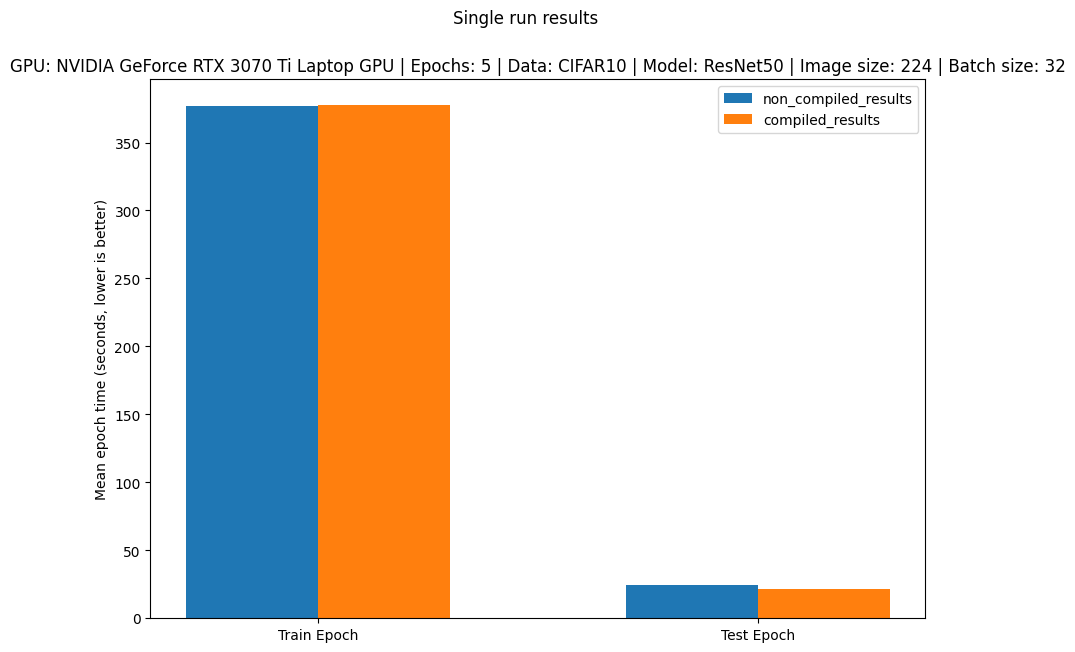

In [87]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/" 
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_multi_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_multi_run}")

# Plot the results and save the figures
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df, 
                      compiled_results=single_run_compile_results_df, 
                      multi_runs=False, 
                      save_path=save_path_multi_run, 
                      save=True)

In [88]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3070_Ti_Laptop_GPU.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3070_Ti_Laptop_GPU.csv


In [89]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS, 
                                        learning_rate=LEARNING_RATE, 
                                        disable_progress_bar=False):
    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    return results

def create_compiled_model():
    """
    Create a compiled PyTorch model and return it.
    """
    model, _ = create_model()
    model.to(device)
    
    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()

    compile_time = compile_end_time - compile_start_time

    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

def train_compiled_model(model=compiled_model, 
                         epochs=NUM_EPOCHS, 
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
    """
    Train a compiled model and return the results.
    """
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(compiled_model.parameters(),
                                 lr=learning_rate)
    
    compile_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=epochs,
                            device=device,
                            disable_progress_bar=disable_progress_bar)
    
    return compile_results

In [90]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 5

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Epoch: 1 | train_loss: 1.2742 | train_acc: 0.5387 | test_loss: 1.0941 | test_acc: 0.6165 | train_epoch_time: 384.1868 | test_epoch_time: 24.2847
Epoch: 2 | train_loss: 0.8114 | train_acc: 0.7139 | test_loss: 0.8861 | test_acc: 0.6917 | train_epoch_time: 380.2609 | test_epoch_time: 24.0976
Epoch: 3 | train_loss: 0.6082 | train_acc: 0.7873 | test_loss: 0.6218 | test_acc: 0.7859 | train_epoch_time: 379.0075 | test_epoch_time: 24.0597
Epoch: 4 | train_loss: 0.4790 | train_acc: 0.8351 | test_loss: 0.5187 | test_acc: 0.8192 | train_epoch_time: 380.4003 | test_epoch_time: 24.1311
Epoch: 5 | train_loss: 0.3761 | train_acc: 0.86

In [91]:
# Go through non_compile_results_multiple_runs and create a dataframe for each run then concatenate them together
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
    result_df = pd.DataFrame(result)
    non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the averages across the multiple runs
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.252870,0.547045,1.063434,0.626498,379.591607,24.191382
1,0.790086,0.721329,0.735817,0.743876,378.608974,24.069257
2,0.588075,0.795052,0.596610,0.793364,377.969215,24.083485
3,0.461518,0.840498,0.516420,0.820953,378.531774,24.018377
4,0.361993,0.873341,0.477640,0.837793,377.649303,23.999476


In [92]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model results
compiled_results_multiple_runs = []

# Run compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    # Train the compiled model (note: the model will only be compiled once and then re-used for subsequent runs)
    results = train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=True)
    compiled_results_multiple_runs.append(results)

Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Time to compile: 0.0004229545593261719 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for compiled model
Epoch: 1 | train_loss: 1.2007 | train_acc: 0.5687 | test_loss: 0.9765 | test_acc: 0.6528 | train_epoch_time: 391.7950 | test_epoch_time: 27.1642
Epoch: 2 | train_loss: 0.7460 | train_acc: 0.7398 | test_loss: 0.6542 | test_acc: 0.7724 | train_epoch_time: 338.1816 | test_epoch_time: 18.5138
Epoch: 3 | train_loss: 0.5486 | train_acc: 0.8093 | test_loss: 0.5316 | test_acc: 0.8140 | train_epoch_time: 335.1513 | test_epoch_time: 18.5058
Epoch: 4 | train_loss: 0.4278 | train_acc: 0.8532 | test_loss: 0.5899 | test_acc: 0.8047 | train_epoch_time: 340.9930 | test_epoch_time: 19.0298
Epoch: 5 | train_loss: 0.3347 | train_acc: 0.8834 | test_loss: 0.4985 | test_acc: 0.8341 | train_epoch_time: 341.9331 | test_epoch_time: 18.9198
[INFO] Run 2 of 3 for compiled model
Epoch: 1 | train_loss: 0.2672 | train_acc: 0.9067 | test_loss: 0.4817 | test_acc: 0.8473 | train_epoch_time: 341.9804 | test_epoch_time: 19.0114
Epoch: 2 | train_loss: 0.1793 | train_acc: 0.9365 | test

In [93]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean() # .index = groupby the epoch number
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.515680,0.816112,0.667333,0.789337,358.691901,21.684956
1,0.329515,0.884697,0.580644,0.821585,340.720882,18.756029
2,0.244817,0.914807,0.511181,0.846679,339.698710,18.749523
3,0.192579,0.933801,0.556254,0.843883,341.332980,18.930899
4,0.154950,0.946091,0.518448,0.856230,341.316235,18.860880


Mean train epoch time difference: -9.015% (negative means faster)
Mean test epoch time difference: -19.424% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/multi_run_NVIDIA_GeForce_RTX_3070_Ti_Laptop_GPU_ResNet50_CIFAR10_224_train_epoch_time.png


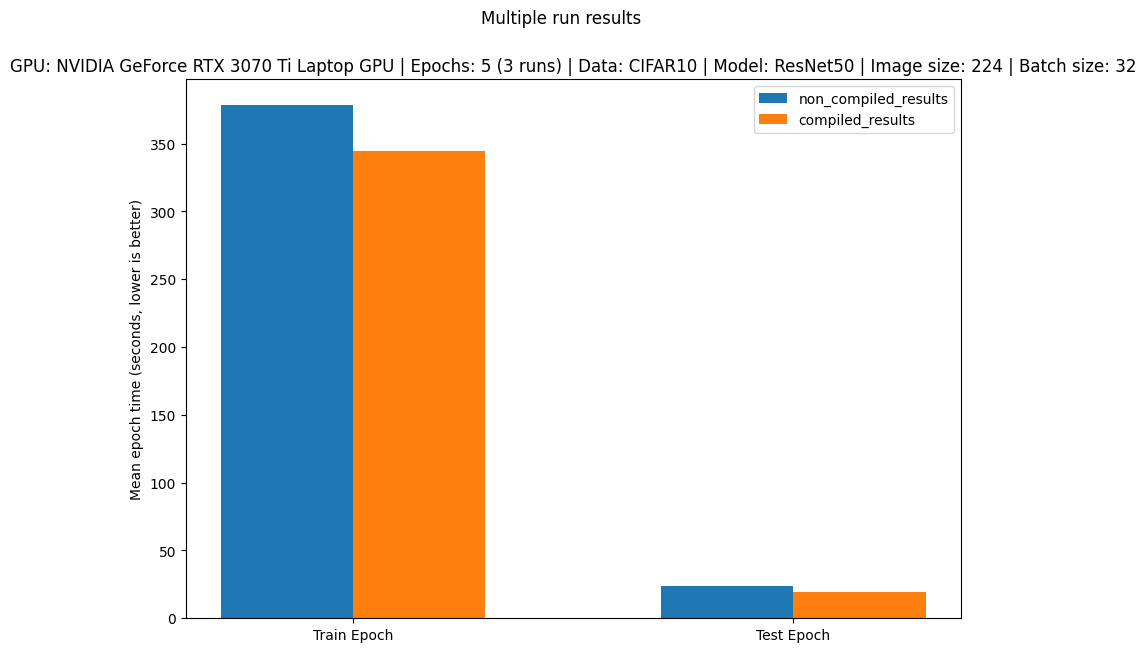

In [94]:
# Create a directory to save the multi-run figure to 
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df, 
                      compiled_results=compile_results_multiple_runs_df, 
                      multi_runs=True, 
                      num_runs=NUM_RUNS, 
                      save_path=save_path_multi_run, 
                      save=True)

In [95]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)

[INFO] Saving experiment 3 non-compiled results to: pytorch_2_results/multi_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3070_Ti_Laptop_GPU.csv
[INFO] Saving experiment 4 compiled results to: pytorch_2_results/multi_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_GeForce_RTX_3070_Ti_Laptop_GPU.csv
